In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
inpath='/content/gdrive/My Drive/Brain'
output_path='/content/gdrive/My Drive'

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
Fully1='/content/gdrive/My Drive/Brain/Volumesf1.npy'

Under1='/content/gdrive/My Drive/Brain/VolumesUnderf1.npy'

Fully2='/content/gdrive/My Drive/Brain/Volumesf2.npy'

Under2='/content/gdrive/My Drive/Brain/VolumesUnderf2.npy'

Fully3='/content/gdrive/My Drive/Brain/Volumesf3.npy'

Under3='/content/gdrive/My Drive/Brain/VolumesUnderf3.npy'

Fully4='/content/gdrive/My Drive/Brain/Volumesf4.npy'

Under4='/content/gdrive/My Drive/Brain/VolumesUnderf4.npy'

FullyS1=np.load(Fully1)
FullyS2=np.load(Fully2)
FullyS3=np.load(Fully3)
FullyS4=np.load(Fully4)
UnderS1=np.load(Under1)
UnderS2=np.load(Under2)
UnderS3=np.load(Under3)
UnderS4=np.load(Under4)

#UnderS3=np.load(Under3)
#Fully_Sampled= np.asarray(FullyS1)
#Undersampled= np.asarray(UnderS1)
Fully_Sampled=np.asarray( np.concatenate((FullyS1,FullyS1,FullyS1,FullyS1),axis=0))
Undersampled=np.asarray(np.concatenate((UnderS1,UnderS2,UnderS3,UnderS4),axis=0))

#from sklearn.model_selection import train_test_split
undersampled_train,undersampled_test,vol_val_train,vol_val_test = train_test_split(Undersampled,Fully_Sampled, test_size=0.2, random_state=0)
  
undersampled_train=undersampled_train.reshape(64,4,128,128,20)
undersampled_train=undersampled_train[:,:,:,:,0:1]
undersampled_train=undersampled_train.reshape(64,4,128,128)
vol_val_train=vol_val_train.reshape(64,4,128,128,20)
vol_val_train=vol_val_train[:,:,:,:,0:1]
vol_val_train=vol_val_train.reshape(64,4,128,128)
undersampled_test=undersampled_test.reshape(16,4,128,128,20)
undersampled_test=undersampled_test[:,:,:,:,0:1]
undersampled_test=undersampled_test.reshape(16,4,128,128)
vol_val_test=vol_val_test.reshape(16,4,128,128,20)
vol_val_test=vol_val_test[:,:,:,:,0:1]
vol_val_test=vol_val_test.reshape(16,4,128,128)








In [ ]:
import keras,os
from keras.models import Model
from keras.layers.merge import add,multiply
from keras.layers import Lambda,Input, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D,Cropping2D, core, Dropout,BatchNormalization,concatenate,Activation
from keras import backend as K
from keras.layers.core import Layer, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from keras.optimizers import *

#from perception.bases.model_base import ModelBase

#class UNETModel(Model):
#	def __init__(self,config=None):
#		super(UNETModel, self).__init__()
#
#		self.patch_height=128
#		self.patch_width = 128
		

#		self.build_model()
#		#self.save('/content/gdrive/My Drive/attention')

def _MiniUnet(input,shape):
		x1 = Conv2D(shape, (3, 3), strides=(1, 1), padding="same",activation="relu")(input)
		pool1=MaxPooling2D(pool_size=(2, 2))(x1)

		x2 = Conv2D(shape*2, (3, 3), strides=(1, 1), padding="same",activation="relu")(pool1)
		pool2 = MaxPooling2D(pool_size=(2, 2))(x2)

		x3 = Conv2D(shape * 3, (3, 3), strides=(1, 1), padding="same",activation="relu")(pool2)

		x=concatenate([UpSampling2D(size=(2,2))(x3),x2],axis=3)
		x = Conv2D(shape*2, (3, 3), strides=(1, 1), padding="same",activation="relu")(x)

		x = concatenate([UpSampling2D(size=(2, 2))(x),x1],axis=3)
		x = Conv2D(shape, (3, 3), strides=(1, 1), padding="same", activation="linear")(x)
		return x
  
  
def expend_as(tensor, rep):
		my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
		return my_repeat

def AttnGatingBlock(x, g, inter_shape):
		shape_x = K.int_shape(x)  # 32
		shape_g = K.int_shape(g)  # 16

		theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
		shape_theta_x = K.int_shape(theta_x)

		phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
		upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)  # 16

		concat_xg = add([upsample_g, theta_x])
		act_xg = Activation('relu')(concat_xg)
		psi = Conv2D(1, (1, 1), padding='same')(act_xg)
		sigmoid_xg = Activation('linear')(psi)
		shape_sigmoid = K.int_shape(sigmoid_xg)
		upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

		# my_repeat=Lambda(lambda xinput:K.repeat_elements(xinput[0],shape_x[1],axis=1))
		# upsample_psi=my_repeat([upsample_psi])
		upsample_psi = expend_as(upsample_psi, shape_x[3])

		y = multiply([upsample_psi, x])

		# print(K.is_keras_tensor(upsample_psi))

		result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
		result_bn = BatchNormalization()(result)
		return result_bn

def UnetGatingSignal(input, is_batchnorm=False):
		shape = K.int_shape(input)
		x = Conv2D(shape[3] * 2, (1, 1), strides=(1, 1), padding="same")(input)
		if is_batchnorm:
			x = BatchNormalization()(x)
		x = Activation('relu')(x)
		return x

def UnetConv2D(input, outdim, is_batchnorm=False):
		shape = K.int_shape(input)
		x = Conv2D(outdim, (3, 3), strides=(1, 1), padding="same")(input)
		if is_batchnorm:
			x =BatchNormalization()(x)
		x = Activation('relu')(x)

		x = Conv2D(outdim, (3, 3), strides=(1, 1), padding="same")(x)
		if is_batchnorm:
			x = BatchNormalization()(x)
		x = Activation('relu')(x)
		return x
def UnetConv2DPro(input, outdim):
		x = Conv2D(outdim, (3, 3), strides=(1, 1), padding="same")(input)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)

		x = Conv2D(outdim, (3, 3), strides=(1, 1), padding="same")(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)

		attn_shortcut=_MiniUnet(input,outdim)

		merge=multiply([attn_shortcut,x])
		result=add([merge,x])
		return result



inputs = Input((128, 128,4))
conv = Conv2D(16, (3, 3), padding='same')(inputs)  # 'valid'
conv = LeakyReLU(alpha=0.3)(conv)

conv1 = UnetConv2D(conv, 32,is_batchnorm=True)  # 32 128
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = UnetConv2D(pool1, 32,is_batchnorm=True)  # 32 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = UnetConv2D(pool2, 64,is_batchnorm=True)  # 64 32
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = UnetConv2D(pool3, 64,is_batchnorm=True)  # 64 16
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

center =UnetConv2D(pool4, 128,is_batchnorm=True)  # 128 8

gating = UnetGatingSignal(center, is_batchnorm=True)
attn_1 = AttnGatingBlock(conv4, gating, 128)
up1 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same',activation="relu")(center), attn_1], axis=3)

gating = UnetGatingSignal(up1, is_batchnorm=True)
attn_2 = AttnGatingBlock(conv3, gating, 64)
up2 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same',activation="relu")(up1), attn_2], axis=3)

gating = UnetGatingSignal(up2, is_batchnorm=True)
attn_3 = AttnGatingBlock(conv2, gating, 32)
up3 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(up2), attn_3], axis=3)

up4 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(up3), conv1], axis=3)


conv8 = Conv2D(4, (1, 1), activation='linear', padding='same')(up4)
#conv8 = core.Reshape((128 * 128,(4)))(conv8)
		############
#act = Activation('linear')(conv8)

model = Model(inputs=inputs, outputs=conv8)
model.compile(optimizer = Adam(lr = 1e-3), loss = 'mean_squared_error')

		#plot_model(model, to_file=os.path.join(checkpoint, "model.png"), show_shapes=True)
		

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 4640        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [ ]:
undersampled_train = np.reshape(undersampled_train, (len(undersampled_train), 128, 128,4))  # adapt this if using `channels_first` image data format
undersampled_test = np.reshape(undersampled_test, (len(undersampled_test), 128, 128,4))  # adapt this if using `channels_first` image data format
vol_val_train = np.reshape(vol_val_train, (len(vol_val_train), 128, 128,4))  # adapt this if using `channels_first` image data format
vol_val_test = np.reshape(vol_val_test, (len(vol_val_test), 128, 128,4))   

In [ ]:
from keras.callbacks import TensorBoard

model.fit(undersampled_train, vol_val_train,
                epochs=100,
                batch_size=1,
                shuffle=True,
                validation_data=(undersampled_test, vol_val_test))
#                callbacks=[TensorBoard(log_dir='/content/gdrive/My Drive/autoencoder')])



Train on 64 samples, validate on 16 samples
Epoch 1/100
64/64 [==============================] - 24s 380ms/step - loss: 0.0210 - val_loss: 0.7307
Epoch 2/100
64/64 [==============================] - 19s 290ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 3/100
64/64 [==============================] - 19s 292ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 4/100
64/64 [==============================] - 19s 291ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 5/100
64/64 [==============================] - 19s 292ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 6/100
64/64 [==============================] - 18s 286ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 7/100
64/64 [==============================] - 18s 286ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 8/100
64/64 [==============================] - 18s 288ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 9/100
64/64 [==============================] - 18s 287ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/100
64/64 [================

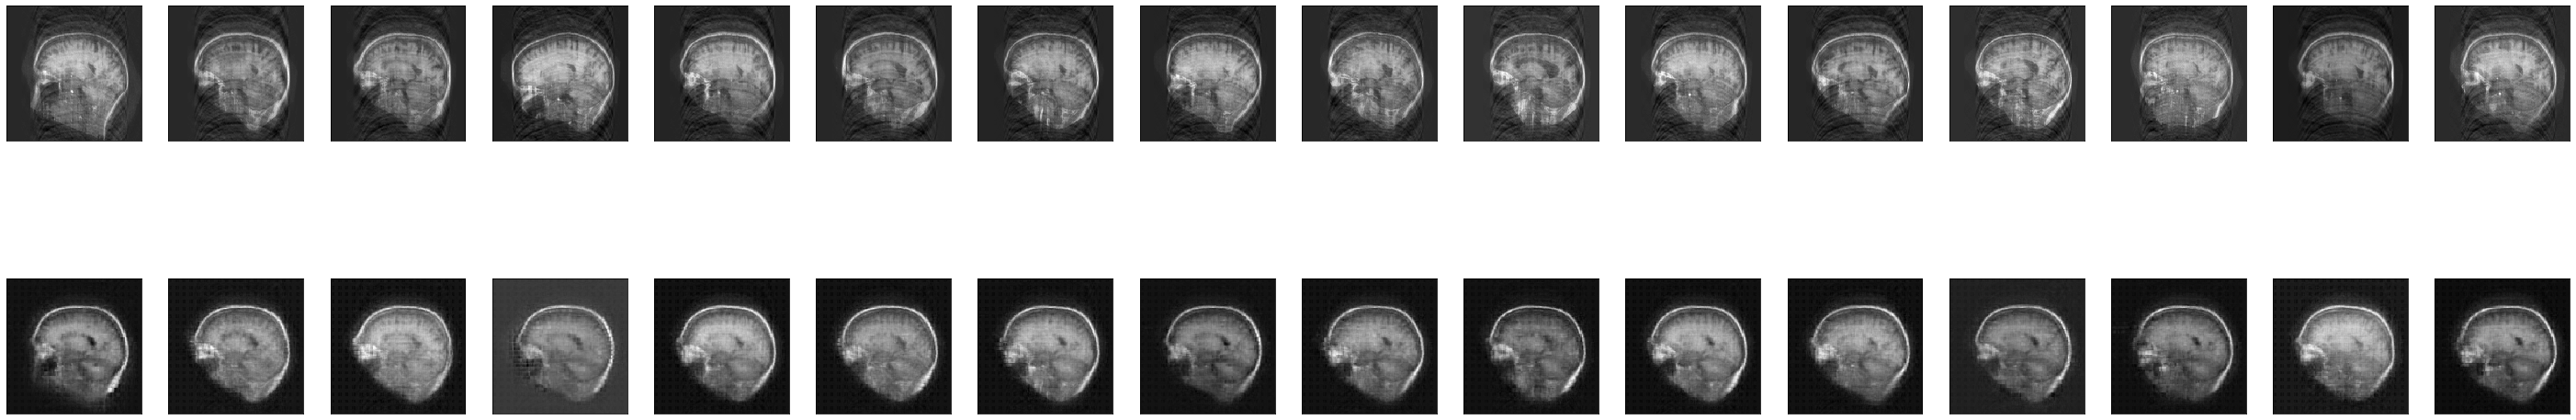

In [ ]:
import matplotlib.pyplot as plt
import pywt
decoded_imgs = model.predict(undersampled_test)

def idwav(imgs):
    imagepred=[]
    for imagef in imgs:
        imagef=imagef.reshape(4,128,128)
        c1,c2,c3,c4= np.array_split(imagef, 4,axis=0)
    
    
        coeffs1=c1,(c2,c3,c4)
        imageff=pywt.idwt2(coeffs1, 'haar')
        
        imageff=imageff.reshape(256,256)
        imagepred.append(imageff)
    imagepred=np.asarray(imagepred,dtype=np.float64)
    return imagepred
  
undersampled_test_input=idwav(undersampled_test)
imagepred=idwav(decoded_imgs)



n = 16
plt.figure(figsize=(50, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(undersampled_test_input[i])##################printing test input
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +n+1)
    plt.imshow(imagepred[i].reshape(256, 256))#######################printing prediction
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
original_images=idwav(vol_val_test)#######fully test images


from skimage.measure import compare_ssim as ssim

for im1,im2 in zip(original_images,imagepred):
    ssim_const = ssim(im1,im2)
                
    print(ssim_const)
      

0.7776916486549323
0.8432540101052258
0.8243961790614294
0.7750829508667805
0.8430218522280124
0.8096838625807139
0.8306147358619187
0.7771983733947383
0.7941322592320763
0.8312292499623425
0.7994135950932598
0.8524521587267624
0.8472318857493721
0.7967516569808512
0.8444631013029485
0.8052557414349608
